# PMT calibration

Notebook to calibrate the PMTs

* Read the histograms
* Calibration using poisson+gauss
  * Plots the distribution and the fit
  * Write parameters into hdf5 and csv
* Compare results with the DB  
  
Author: J.A. Hernando

version: v02

In [1]:
from __future__ import print_function

### Revision

In [2]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

22/11/2016   14:49:34


### Dependencies

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tables
import pandas as pd
import time

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [6]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC:/Users/hernando/Software/root/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC:/Users/hernando/Software/lib:/Users/hernando/Software/lib


### DB  

In [7]:
import Database.loadDB as db

pmtdb = db.DataPMT()
pmtdb

,channel,pmtid,active,x,y,coeff_c,coeff_blr,adc_to_pes,noise_rms
0,0,1,1,-23.941401,65.778503,0.000003,0.001632,-22.9168,0.7060
1,18,3,1,-44.995098,-53.623100,0.000003,0.001632,-23.7510,0.8744
2,1,2,1,68.936501,-12.155400,0.000003,0.001611,-25.3008,0.7213
3,19,4,1,0.000000,185.000000,0.000003,0.001599,-25.9984,0.7624
4,27,C,1,-118.916000,141.718002,0.000003,0.001567,-23.7074,0.7921
5,26,B,1,-182.188995,32.124901,0.000004,0.001650,-20.8927,0.8660
6,9,A,1,-160.214996,-92.500000,0.000003,0.001593,-22.1340,0.7062
7,8,9,1,-63.273701,-173.843002,0.000003,0.001612,-33.0993,0.7278
8,23,8,1,63.273701,-173.843002,0.000003,0.001601,-20.4377,0.7303
9,22,7,1,160.214996,-92.500000,0.000003,0.001593,-25.1698,0.7160


### PMT calibration data

In [8]:
indir='/Users/hernando/Investigacion/NEXT/Data/NEWStar/pmtcalib/161117/'
irun='2845'
infile='pmtCal_r'+irun

In [9]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'_led.txt',nsensors=12)
#caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/Data/NEWStar/pmtcalib/161117/pmtCal_r2845_led.txt
number of sensors with data 12


In [10]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [11]:
# take the reference values
xbins = called.xbins
indexes = list(called.indexes)
indexes.sort()

## Calibration

In [12]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=3)
ps0 = np.array([35000., 0., 22., 1., 7., 7.])
bounds = ((0., -10., 10., 0.0, 2., 2.),(200000., 10., 40., 2., 15., 15.))

chi2, pss, covs = sc.cal_fit_poissongauss(called, indexes, ngauss=4, ps0=ps0, bounds=bounds)
zpss = zip(indexes,pss)

fitting data...


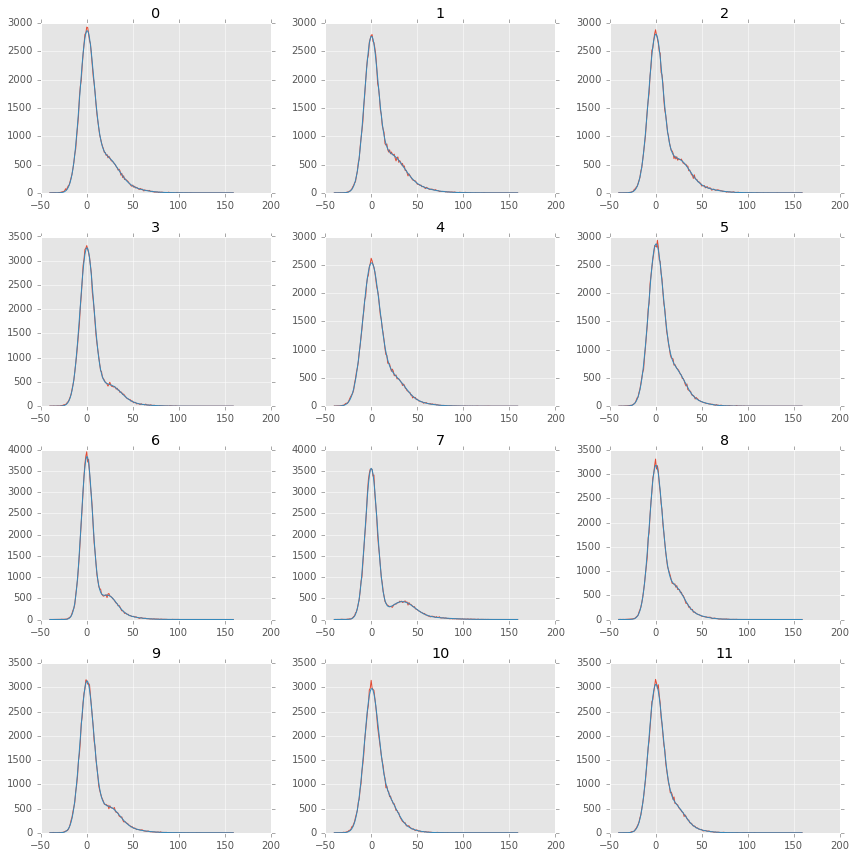

In [13]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_fits.pdf')
fun = sc.ffun_poissongauss
fig = sc.polo_cal_fit(called,indexes,pss,fun,xrange=(-40.,160.))
if (pdf): pdf.savefig(fig)
pdf.close()

In [14]:
pan = sc.cal_fit_poissongauss_panda(indexes, chi2, pss, covs)
pan['sensorID'] = pan['indexes']

In [15]:
pan

,indexes,sensorID,chi2,ntot,sntot,pedestal,spedestal,gain,sgain,pes,spes,noise,snoise,noisepe,snoisepe
0,0,0,0.782620,74662.318153,249.862044,0.013744,0.076365,21.239780,0.647245,0.348485,0.013933,7.760556,0.053317,10.082450,0.440671
1,1,1,0.929870,74726.053796,272.848217,-0.052219,0.075383,21.222503,0.754324,0.429319,0.018204,7.566736,0.064665,11.601208,0.486340
2,2,2,0.870505,74714.815599,263.914485,0.017234,0.069579,24.365879,0.460260,0.326005,0.008861,7.933839,0.048721,9.706302,0.375770
3,3,3,0.843616,74673.374534,258.953673,0.025597,0.050557,24.288904,0.492282,0.223499,0.006390,7.471764,0.037853,10.230921,0.381547
4,4,4,0.606614,74672.944628,221.904623,0.011042,0.094291,24.220903,0.623410,0.267645,0.010801,9.313656,0.060883,8.515222,0.485612
5,5,5,0.758644,74731.612558,246.011032,0.241077,0.089053,21.364669,0.488915,0.279771,0.010507,8.090104,0.053654,6.668986,0.426906
6,6,6,0.878506,74706.108057,263.548374,0.111136,0.038797,22.085247,0.296951,0.251918,0.004991,6.143575,0.028550,8.612919,0.262748
7,7,7,1.066419,74705.378244,291.581221,0.089592,0.034450,33.299607,0.241748,0.248807,0.002951,6.584548,0.027784,12.396136,0.250682
8,8,8,0.670332,74739.517285,230.657786,0.124641,0.063338,20.322489,0.390943,0.298544,0.008725,7.178406,0.039270,7.389815,0.321679
9,9,9,0.760928,74757.785652,246.190254,0.082616,0.053632,23.642494,0.422799,0.272492,0.006983,7.451379,0.038290,9.639637,0.340297


In [16]:
pan.to_hdf(indir+'calf_R'+irun+'_pg_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_pg_panda.csv')

That's all folks!

## Comparison with the DB

In [17]:
def polo_par_compare(val1, eval1, val2, eval2, label1='DB', label2='IC', xlim=(-2, 14)):
    fig, ax = plt.subplots()
    ids = range(len(val1))
    ax.errorbar(ids, val1, yerr=eval1, fmt='o', color='red', label=label1)
    ax.errorbar(ids, val2, yerr=eval2, fmt='*', color='blue', label=label2)
    ax.set_xlim(xlim)
    ax.set_ylim(0, max(max(val1), max(val2))+5)
    ax.legend()
    return fig

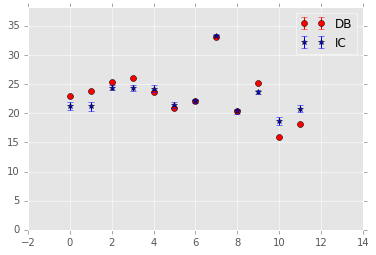

In [18]:
pdf = None
pdf = pdf = PdfPages(indir+'calf_R'+irun+'_compare_DB.pdf')
fig = polo_par_compare(-1*pmtdb['adc_to_pes'], np.zeros(12), pan['gain'], pan['sgain'])
pdf.savefig(fig)
# fig = polo_par_compare(pmtdb['Sigma'], np.zeros(12), pan['noisepe'], pan['snoisepe'])
# pdf.savefig(fig)